In [33]:
%matplotlib inline
import numpy as np
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import tifffile
from skimage import color
from skimage import img_as_ubyte
from pystackreg import StackReg
from matplotlib import animation
from IPython.display import HTML
import json
import cv2
import statsmodels.api as sm

In [62]:
def load_images(image_paths):
    images = []
    for p in image_paths:
        im = tifffile.imread(p)
        im = color.rgb2gray(im)
        im = np.asarray(img_as_ubyte(im))
        images.append(im)
    return np.array(images)

def save_images(images, dest):
    os.makedirs(dest, exist_ok=True)
    nimages = images.shape[0]
    fmt  = '{:0' + str(int(np.ceil(np.log10(max(1,abs(nimages)+1))))) + 'd}.tif'
    for i in range(nimages):
        p = os.path.join(dest, fmt.format(i+1))
        tifffile.imwrite(p, img_as_ubyte(images[i]))

def save_video(images, dest_dir, basename='video', codec='MP4V', fps=6):
    foutrcc = cv2.VideoWriter_fourcc(*codec)
    width = images.shape[2]
    height = images.shape[1]
    
    if codec in ['MP4V']:
        ext = 'mp4'
    elif codec in ['XVID']:
        ext = 'avi'
    
    dest_gray = os.path.join(dest_dir, '{}.gray.{}'.format(basename, ext))
    video_gray  = cv2.VideoWriter(dest_gray, foutrcc, fps, (width, height), isColor=False)
    
    dest_color = os.path.join(dest_dir, '{}.color.{}'.format(basename, ext))
    video_color = cv2.VideoWriter(dest_color, foutrcc, fps, (width, height), isColor=True)
    
    for i in range(images.shape[0]):
        video_gray.write(images[i])
        video_color.write(cv2.applyColorMap(images[i], cv2.COLORMAP_JET))
    video_gray.release()
    video_color.release()
    
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.
    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.
    Returns:
    --------
        mask : A numobservations-length boolean array.
    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh
#end is_outlier()


def max_exclude_outliers(data, threshold=3.5):
    return data[(~is_outlier(data, threshold))].max()

def crop_images(images, x1=None, y1=None, x2=None, y2=None):
    if x1 is None: 
        x1 = 0
    if y1 is None: 
        y1 = 0
    if x2 is None: 
        x2 = images.shape[2]
    if y2 is None:
        y2 = images.shape[1]
        
    return images[:, y1:y2, x1:x2]

def calculate_norm_factors(images, threshold=1.05):
    sums = np.mean(np.array(images), axis=(1,2))
    lowess = sm.nonparametric.lowess(sums, np.arange(images.shape[0]), frac=0.2)
    coeff = lowess[:, 1] / sums
    coeff[coeff < 0] = 0
    #print(coeff, lowess[:, 1])
    
    #sums = np.median(np.array(images), axis=(1,2))
    #lowess = sm.nonparametric.lowess(y, np.linspace(0, images.shape[0], frac=0.1)
    #coeff = np.ones(sums.shape[0])
    #for i in range(1,len(sums)-1):
    #    f = sums[i-1]
    #    l = sums[i+1]
    #    c = sums[i]
    #    a = np.mean([f, l])
    #    r = a / sums[i]
    #    if c < f and c < l and r > threshold:
    #        coeff[i] = r
    return (coeff, sums, sums * coeff)

def apply_norm_factors(coeff, images):
    corrected_images = images * coeff[:, None, None]
    corrected_images[corrected_images > 255] = 255
    corrected_images[corrected_images < 0] = 0
    return corrected_images.astype('uint8')

def correct_intensity_fluctuations(images):
    factors = calculate_norm_factors(images)
    #plot_norm_factors(*factors)
    corrected_images = apply_norm_factors(factors[0], images)  #default = 0
    return corrected_images, factors

def normalize_intensity(images, exclude_outliers=True, threshold=3.5):
    images = images.astype('float32')
    if exclude_outliers:
        datamax = max_exclude_outliers(images.ravel(), threshold=threshold)
    else:
        datamax = images.max()
    datamin = images.min()
    
    norm = ((images - datamin) / (datamax - datamin)) * 255
    norm[norm > 255] = 255
    norm[norm < 0] = 0
    return norm.astype('uint8')
    

def plot_norm_factors(coeff, uncorrected, corrected):
    fig, axs = plt.subplots(2, 1)
    
    axs[0].plot(uncorrected)
    axs[0].plot(corrected)
    axs[0].set_ylabel("Intensity Sum")
    
    axs[1].plot(coeff)
    axs[1].set_ylabel("Correction Factor")
    
    return fig, axs

def visualize_frames(images):
    vmin = images.min()
    vmax = images.max()
    
    fig = plt.figure()
    im = plt.imshow(images[0,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.close()
    
    def init():
        im.set_data(images[0,:,:])

    def animate(i):
        im.set_data(images[i,:,:])
        return im
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=images.shape[0], interval=100)
    return HTML(anim.to_html5_video())


def register_images(images, **kwargs):
    sr = StackReg(StackReg.RIGID_BODY)
    registered = sr.register_transform_stack(images, **kwargs)
    registered[registered > 255] = 255
    registered[registered < 0] = 0
    return registered.astype('uint8')

def get_default_processing_opts():
    return {
        'dry': False, # no saving output
        'crop': {},
        'inorm': {
            'enabled': True,
            'kwargs': {'exclude_outliers': True, 'threshold':3.5}
        },
        'icorr': {'enabled': True},
        'reg': {
            'enabled': True,
            'kwargs': {'reference': 'mean'} #default = previous
        },
        'dest': 'processed',
        'mask': None 
    }

def mask_images(images, mask_path):
    mask = load_images([mask_path])[0]
    mask[mask>0]=1
    images=images[:,...]*mask
    return images

def process_dataset(path, opts):
    print("working on {}".format(path))
    
    if not opts['dry']:
        meta_dir = os.path.join(path, opts['dest'], 'metadata')
        os.makedirs(meta_dir, exist_ok=True)
    
        with open(os.path.join(meta_dir, 'options.json'), 'w') as outfile:
            json.dump(opts, outfile, indent='\t')
    
    # load images
    print("  - Loading images...")
    images = load_images(sorted(glob.glob(os.path.join(path, '*.tif'))))
    #print(images.dtype)
    
    # crop images according to options
    print("  - Cropping images...")
    images = crop_images(images, **opts['crop'])
    #print(images.dtype)
    
  
    
    
    # normalize image intensity (linear stretch)
    if opts['inorm']['enabled']:
        print("  - Normalizing image intensity")
        images = normalize_intensity(images, **opts['inorm']['kwargs'])
   
    if opts['mask'] is not None:
        print("  - masking images...")
        images = mask_images(images, opts['mask'])
        

    # correct for intensity fluctuations
    if opts['icorr']['enabled']:
        print("  - Correcting intensity fluctuations...")
        images, factors = correct_intensity_fluctuations(images)
        fig, _ = plot_norm_factors(*factors)
        if not opts['dry']:
            fig.savefig(os.path.join(meta_dir, 'intensity_norm.png'))
            fig.savefig(os.path.join(meta_dir, 'intensity_norm.pdf'))
        #print(images.dtype)
        
    
   
    
    # correction for movement
    if opts['reg']['enabled']:
        print("  - Correcting for movement...")
        images = register_images(images, **opts['reg']['kwargs'])
        #print(images.dtype)
    
    if not opts['dry']:
        # save images
        print("  - Saving images...")
        save_images(images, os.path.join(path, opts['dest']))

        # save a video for easier inspection
        print("  - Saving video...")
        save_video(images, os.path.join(path, opts['dest']))
    
    return images
    

In [59]:
base_dir = r'/Users/garvitgupta/Downloads/front-tracking-main/data'
#stains = ['Dextran', 'OVA']
samples = [os.path.basename(p) for p in glob.glob(os.path.join(base_dir, '*'))]

needs_crop = ["898", "900", "903", "904", "905", "906", "909"]

for sample in samples:
  #  for stain in stains:
        path = os.path.join(base_dir, sample) #,stain)
        opts = get_default_processing_opts()
        
        if sample in needs_crop:
            opts['crop']['y1'] = 75
        
        frames = process_dataset(path, opts)
        visualize_frames(frames)

working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/10
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/31
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/47
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/84
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/118
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Correcting for movement...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/126
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Correcting for movement...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/9
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...


/var/folders/3n/fcpvb3h559x4r03p9bdnxsy40000gn/T/ipykernel_3454/213230149.py:90: RuntimeWarning: divide by zero encountered in true_divide
  coeff = lowess[:, 1] / sums


  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/12
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/75
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/76
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/77
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/79
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/83
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/88
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - masking images...
  - Correcting intensity fluctuations...
  - Saving images...
  - Saving video...


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


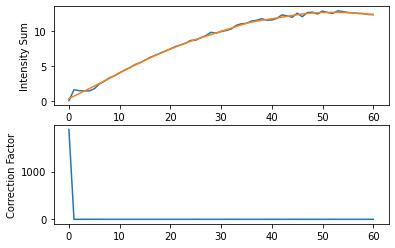

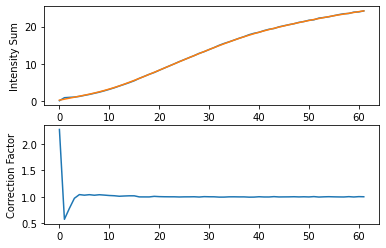

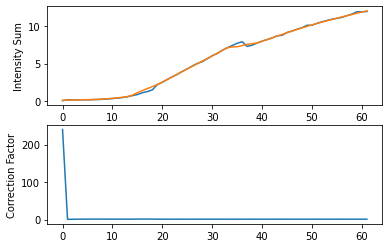

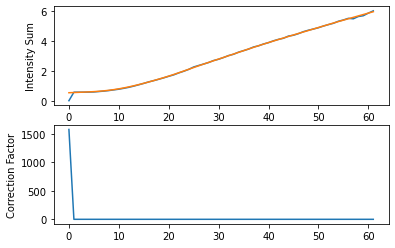

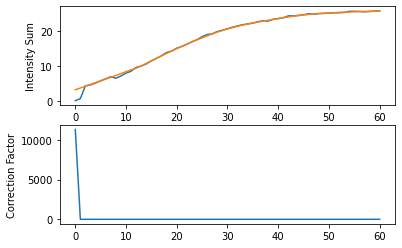

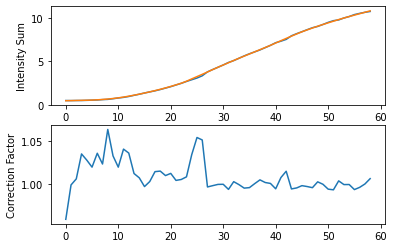

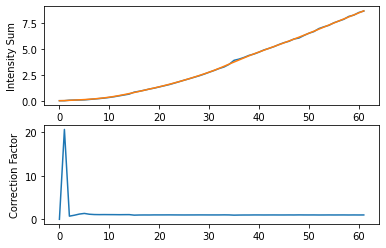

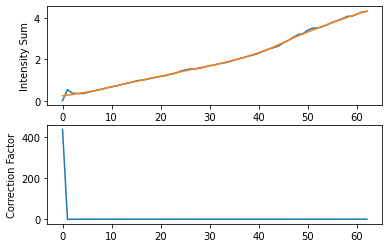

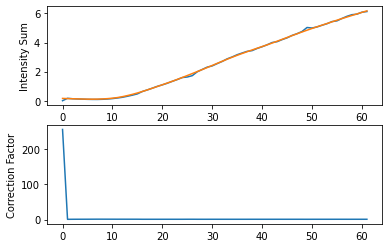

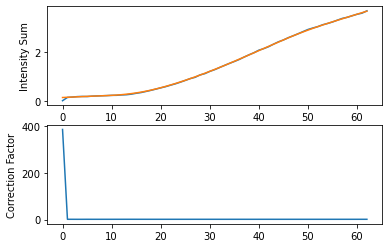

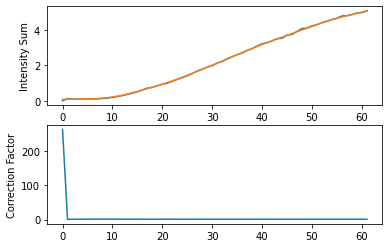

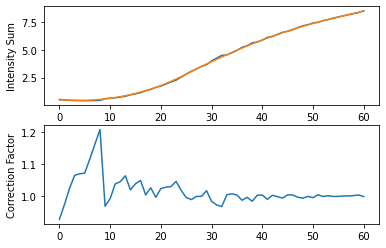

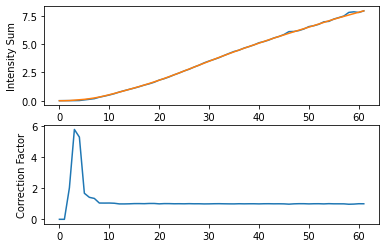

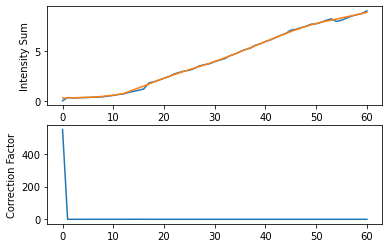

In [39]:
##Mean=previous set

#10
opts = get_default_processing_opts()
opts['reg']['enabled'] = False
opts['inorm']['kwargs']['exclude_outliers'] = False 
process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/10", opts)

#31
opts = get_default_processing_opts()
opts['reg']['enabled'] = False
opts['inorm']['kwargs']['exclude_outliers'] = False 
process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/31", opts)

#47
opts = get_default_processing_opts()
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_47.tif"
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/47", opts)

#84
opts = get_default_processing_opts()
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_84.tif"
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/84", opts)

#118
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = True  
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/118", opts)

#126
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = True
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/126", opts)


####Sm22a-Cre-Folder####


#9
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/9", opts)

#12
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/12", opts)

#75
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_75.tif"
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/75", opts)

#76
opts = get_default_processing_opts()
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_76.tif"
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/76", opts)

#77
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_77.tif"
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/77", opts)


#79
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/79", opts)


#83
opts = get_default_processing_opts()
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/83", opts)

#88
opts = get_default_processing_opts()
opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_88.tif"
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = False
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/88", opts)



working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/9
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...


/var/folders/3n/fcpvb3h559x4r03p9bdnxsy40000gn/T/ipykernel_3454/4235768669.py:90: RuntimeWarning: divide by zero encountered in true_divide
  coeff = lowess[:, 1] / sums


  - Correcting for movement...


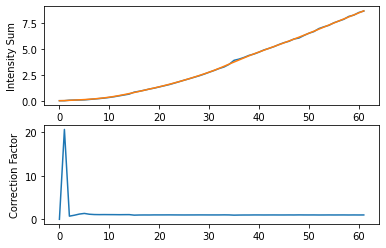

In [63]:
opts = get_default_processing_opts()
opts['dry'] = True  

#opts['icorr']['enabled'] = False  #image correction in intensity
#opts['inorm']['enabled'] = False

#opts['mask'] = "/Users/garvitgupta/Downloads/Background_Masking_Images/Background_88.tif"
#opts['inorm']['kwargs']['exclude_outliers'] = False 


#opts['reg']['enabled'] = False
opts['inorm']['kwargs']['exclude_outliers'] = False 
opts['reg']['enabled'] = True
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/9", opts)
#frames = frames - frames[0]  
visualize_frames(frames)

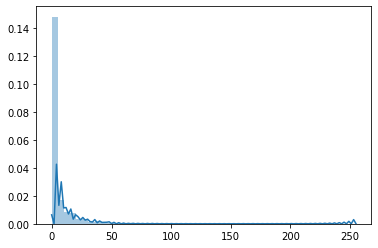

In [95]:
sns.distplot(frames)

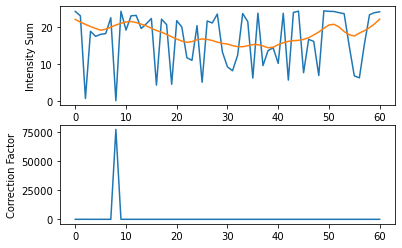

In [58]:
images = load_images(glob.glob(os.path.join(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+/118", '*.tif')))


images, factors = correct_intensity_fluctuations(images)
plot_norm_factors(*factors)
visualize_frames(images)








In [30]:
sr = StackReg(StackReg.RIGID_BODY)

tmats_dex = sr.register_stack(images_dex[:, :, 500:])
reg_dex = sr.transform_stack(images_dex)
reg_dex[reg_dex > 255] = 255
reg_dex[reg_dex < 0] = 0
reg_dex = reg_dex.astype('uint8')

reg_ova = sr.transform_stack(images_ova)
tmats_dex = sr.register_stack(images_dex[:, :, 500:])
reg_ova[reg_ova > 255] = 255
reg_ova[reg_ova < 0] = 0
reg_ova = reg_ova.astype('uint8')

In [2]:
images = load_images(glob.glob(os.path.join(r"/Users/garvitgupta/Downloads/front-tracking-main/data/10", '*.tif')))
images, factors = correct_intensity_fluctuations(images)
visualize_frames(images)
plot_norm_factors(*factors)

NameError: name 'load_images' is not defined

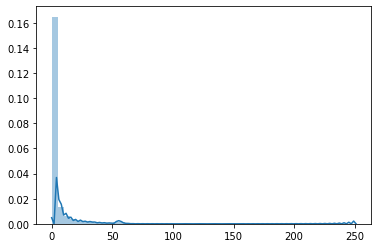

In [35]:
sns.distplot(images_ova)

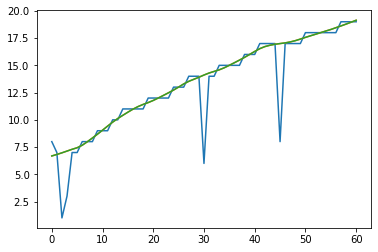

In [66]:
images = load_images(glob.glob(os.path.join(r"F:\Max_FrontTracking\test_experiment1\data\906\Dextran", '*.tif')))
sums = np.median(np.array(images), axis=(1,2))
lowess = sm.nonparametric.lowess(sums, np.arange(images.shape[0]), frac=0.2)
factors = lowess[:, 1] / sums

plt.plot(sums)
plt.plot(lowess[:, 1])
plt.plot(sums * factors)

In [75]:
cimages = images * factors[:, None, None]
visualize_frames(image_histogram_equalization(cimages)[0])

In [74]:
image_histogram_equalization(cimages)[0].shape

(61, 1440, 1920)

In [98]:
opts = get_default_processing_opts()
opts['icorr']['enabled'] = False
process_dataset(r"F:\Max_FrontTracking\test_experiment1\data\4.14.21 Injection 2\OVA", opts)

working on F:\Max_FrontTracking\test_experiment1\data\4.14.21 Injection 2\OVA
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting for movement...
  - Saving images...
  - Saving video...


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

1

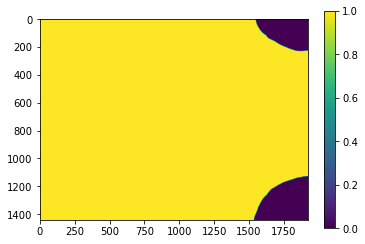

In [28]:
mask = load_images(["/Users/garvitgupta/Downloads/Background_Masking_Images/Background_47.tif"]) [0]
mask
mask[mask>0]=1
plt.imshow(mask)
plt.colorbar()
mask.max()

working on /Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/127
  - Loading images...
  - Cropping images...
  - Normalizing image intensity
  - Correcting intensity fluctuations...
  - Correcting for movement...


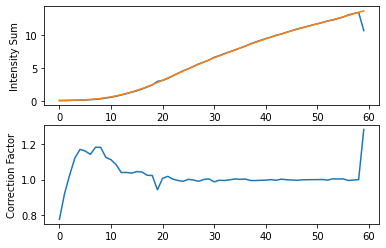

In [53]:
##Mean=previous set

opts = get_default_processing_opts()


opts['dry'] = True  

opts['reg']['enabled'] = True
opts['inorm']['kwargs']['exclude_outliers'] = False 
frames = process_dataset(r"/Users/garvitgupta/Downloads/front-tracking-main/data_Twist_CKO+_Sm22a-Cre/127", opts)
